# Library

In [1]:
import os, sys, time, json, copy, glob, random, datetime
import scipy.sparse as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from tqdm import tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter as Param
from torch.nn import CosineEmbeddingLoss

In [3]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

In [4]:
from torch_geometric.nn.models import GAE
from torch_geometric.nn.conv import GCNConv, RGCNConv, MessagePassing
from torch_geometric.data import Data
from torch_geometric.utils import add_self_loops, degree

In [5]:
import networkx as nx
from networkx.algorithms import bipartite
from networkx.drawing.layout import bipartite_layout

In [6]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
sns.set(style='darkgrid')

# Utils

In [7]:
def get_parent_path(pth, depth=1):
    for _ in range(depth):
        pth = os.path.dirname(pth)
    return pth

In [8]:
def glob_files(pth):
    for f in glob.glob(os.path.join(pth, '*')):
        print(f)

In [9]:
def get_pair(arr):
    return set([(l[0], l[1]) for l in arr.T.tolist()])

In [10]:
def union_set(s1,s2):
    return s1.union(s2)

In [11]:
def measure_time(txt, time_begin, time_fin):
    time = time_fin - time_begin
    print("{}: {:0.3f}".format(txt, time))

In [12]:
def get_initial_feat(num_nodes, dim):
    x = torch.Tensor(num_nodes, dim)
    x = x.data.normal_(std=1/np.sqrt(dim))
    return x

In [13]:
def count_unique_ids(var):
    if isinstance(var, pd.DataFrame):
        ret = len(var['MyID'].unique())
        return ret
    else:
        try:
            ret = len(set([x['id'] for x in var.values()]))
            return ret
        except:
            raise Exception("Dtype error: Node file")

In [14]:
def to_undirected(edge_index, n_src, edge_type=None, is_bipartite=True):
    if is_bipartite:
        edge_index[1] += n_src
    rev_edge_index = edge_index.clone()
    rev_edge_index[0,:], rev_edge_index[1,:] = edge_index[1,:], edge_index[0,:]

    if edge_type is None:
        return torch.cat([edge_index, rev_edge_index], dim=1)
    else:
        return torch.cat([edge_index, rev_edge_index], dim=1), torch.cat([edge_type, edge_type])

In [62]:
def load_nodes(path, keys):
    # load node dataframes
    nodes = dict()
    for key in keys:
        filepath = os.path.join(path, "Node", "{}.csv".format(key))
        if os.path.exists(filepath):
            nodes[key] = pd.read_csv(filepath)
        else:
            print("{} node file does not exist".format(key))
    return nodes

In [63]:
def load_edges(path, unweighted_keys, weighted_keys):
    edge_indexes = dict()
    edge_weights = dict()
    
    # load network data (unweighted)
    for key in unweighted_keys:
        filepath = os.path.join(path, 'Edge', "{}.npy".format(key))
        if os.path.exists(filepath):
            edge = sp.coo_matrix(np.load(filepath))
            edge = Tensor(np.array([edge.row, edge.col])).long()
            edge_indexes[key] = edge
        else:
            print("{} network file does not exist".format(key))
    
    # load network data (weighted)
    for key in weighted_keys:
        filepath = os.path.join(path, 'Edge', "{}.npy".format(key))
        if os.path.exists(filepath):
            edge = np.load(filepath)
            row, col = edge.nonzero()
            edge_indexes[key] = Tensor([row, col]).long()
            edge_weights[key] = Tensor(np.array([edge[i][j] for i,j in zip(row, col)]))
        else:
            print("{} network file does not exist".format(key))
    
    return edge_indexes, edge_weights

In [64]:
def load_embs(nodes, keys, nums, MXLEN=1000):
    embs = dict()
    drug_dim = 2048
    prot_dim = MXLEN
    
    # Drug
    if 'drug_ecfp' in keys:
        mat = np.zeros((nums['drug'], drug_dim))
        for myid in tqdm(range(nums['drug'])):
            sm = nodes['drug'][nodes['drug'].MyID==myid]
            vec = sm['ECFP'].iloc[0][1:-1].replace(',','').split()
            for x in vec:
                mat[myid][int(x)] = 1
        embs['drug_ecfp'] = mat
    
    # Protein
    if 'protein_seq' in keys:
        seq = nodes['protein']['Sequence'].values
        uniq_chars = set()
        char_to_id = {}
        for line in seq:
            uniq_chars = uniq_chars.union(set(list(line)))
        for e,x in enumerate(list(uniq_chars)):
            char_to_id[x] = e
        mat = np.empty((len(seq), len(char_to_id), prot_dim))
        for i,s in enumerate(tqdm(seq)):
            if len(s) > MXLEN:
                s = s[:MXLEN]
            for j,c in enumerate(s):
                mat[i][char_to_id[c]][j] = 1
        embs['protein_seq'] = mat
    
    return embs

In [18]:
def describe_dataset(data, nodes, edges, edge_symbols, conf):
    
    line = "#"*40
    src_node, tar_node = conf['target_network'].split('_')
    print(line)
    
    # Task type
    task_type = conf['task_type']
    print("Task  : {}".format(task_type))
    print("Target: {}".format(conf['target_network']))
    print(line)
    
    # Dataset
    print('Node counts >>')
    for key in nodes:
        print('\t{}: {}'.format(key, data['n_{}'.format(key)]))

    print("\nEdge counts >>")
    for key in edges:
        src, tar, *diff = key.split('_')
        if src==tar:
            print('\t{}: {}'.format(key, data["{}_edge_index".format(edge_symbols[key])].shape[1]))
        else:
            print('\t{}: {}'.format(key, data["{}_edge_index".format(edge_symbols[key])].shape[1]//2))
    print(line)
    
    # Link prediction
    print("Node splits >> ")
    print("\tInternal {} nodes: {}".format(src_node, data.internal_src_index.shape[0]))
    print("\tInternal {} nodes: {}\n".format(tar_node, data.internal_tar_index.shape[0]))
    print("\tExternal {} nodes: {}".format(src_node, data.external_src_index.shape[0]))
    print("\tExternal {} nodes: {}".format(tar_node, data.external_tar_index.shape[0]))
    print(line)
    
    
    # Train, Valid, Test
    print("Edge splits >> ")
    for i in range(conf['cv']):
        print("\tTrain (cv-{}): {} >> {}".format(i, "INT", data.train_edge_index[i].shape[1]))
        print("\tValid (cv-{}): {} >> {}\n".format(i, "INT" if task_type=='transductive' else "EXT", data.valid_edge_index[i].shape[1]))
    print("\tTest: {} >> {}".format("INT" if task_type=='transductive' else "EXT", data.test_edge_index.shape[1]))
    print(line)

In [19]:
# Data partitioning considering drug node order and ICD-11 classification 
def DrugRepositioning_edge_split(dz_edge_index, diz_df):
    train_edge_index = []
    test_edge_index = []
    
    # drug - disease pair
    dz_pairs = defaultdict(list)
    for src, tar in dz_edge_index.T:
        src = src.item()
        tar = tar.item()
        dz_pairs[src].append(tar)
    
    # Drugs: Degree >= 2
    drugs = dz_edge_index[0].tolist()
    drug_src_counts = Counter(drugs)
    test_drug_id = [k for k,v in drug_src_counts.items() if v>=2]
    
    # Disease: No overlapping ICD-11 classifications
    for did in test_drug_id:
        tars = dz_pairs[did]
        tmp = diz_df[diz_df['MyID'].isin(tars)]
        diz_cats = tmp['ICD-11_Category'].values

        if len(set(diz_cats)) <= 1:
            continue
        else:
            picked_cat = np.random.choice(diz_cats)
            picked_diz = tmp[tmp['ICD-11_Category']==picked_cat]
            for zid in picked_diz.MyID:
                test_edge_index.append([did, zid])
            
    # split train-test
    test_set = set([(x,y) for x,y in test_edge_index])
    for x,y in dz_edge_index.T:
        x = x.item()
        y = y.item()
        if (x,y) not in test_set:
            train_edge_index.append([x,y])
        else:
            pass
    
    train_edge_index = Tensor(np.array(train_edge_index)).T.long()
    test_edge_index = Tensor(np.array(test_edge_index)).T.long()
    return train_edge_index, test_edge_index

In [20]:
# Data partitioning without considering drug repositioning
def DrugProtein_edge_split(dp_edge_index, train_ratio):
    train_edge_index = []
    test_edge_index = []
    n_edge = dp_edge_index.shape[1]
    
    rd = np.random.binomial(1, train_ratio, n_edge)
    train_mask = rd.nonzero()[0]
    test_mask = (1-rd).nonzero()[0]
    
    train_index = dp_edge_index[:, train_mask]
    test_index = dp_edge_index[:, test_mask]
    
    train_edge_index = Tensor(np.array(train_index)).long()
    test_edge_index = Tensor(np.array(test_index)).long()
    
    return train_edge_index, test_edge_index

In [21]:
def split_train_valid_edges(edge_index, train_ratio=0.8, cv=1):
    n_edge = edge_index.shape[1]
    ret_train, ret_valid = [], []
    
    if cv==1:
        rd = np.random.binomial(1, train_ratio, n_edge)
        train_mask = rd.nonzero()[0]
        valid_mask = (1-rd).nonzero()[0]
        
        train_index = edge_index[:, train_mask]
        valid_index = edge_index[:, valid_mask]
        
        ret_train.append(train_index.long())
        ret_valid.append(valid_index.long())
    
    else:
        rd = np.random.permutation(np.arange(n_edge)%cv)
        for i in range(cv):
            train_index = edge_index[:, rd!=i]
            valid_index = edge_index[:, rd==i]
            ret_train.append(train_index.long())
            ret_valid.append(valid_index.long())
    
    return ret_train, ret_valid

In [22]:
def split_inductive_edges(edge_index, split_ratio=0.5):
    n_edge = edge_index.shape[1]
    ret_valid = []

    rd = np.random.binomial(1, split_ratio, n_edge)
    valid_mask = rd.nonzero()[0]
    test_mask = (1-rd).nonzero()[0]

    valid_index = [edge_index[:, valid_mask]]
    test_index = edge_index[:, test_mask]
    
    return valid_index, test_index

In [23]:
def remove_edge_from_mask(edge_index, edge_weight=None, src_mask_index=None, tar_mask_index=None):
    ret_index, ret_weight = [], []
    is_mask_src = (src_mask_index is not None)
    is_mask_tar = (tar_mask_index is not None)
    
    # unweighted edge index
    if edge_weight is None:
        for pair in edge_index.T.numpy():
            flg = True
            if is_mask_src and pair[0] in src_mask_index:
                flg = False
            if is_mask_tar and pair[1] in tar_mask_index:
                flg = False
            if flg:
                ret_index.append(pair)
        ret_index = Tensor(np.array(ret_index).T).long()
        return ret_index
    
    # weighted edge index
    else:
        for pair, weight in zip(edge_index.T.numpy(), edge_weight.T):
            flg = True
            if is_mask_src and pair[0] in src_mask_index:
                flg = False
            if is_mask_tar and pair[1] in tar_mask_index:
                flg = False
            if flg:
                ret_index.append(pair)
                ret_weight.append(weight)
        ret_index = Tensor(np.array(ret_index).T).long()
        ret_weight = Tensor(np.array(ret_weight))
        return ret_index, ret_weight

In [24]:
def unseen_edge_split(data, edge_symbols, weighted_edge_names, unseen_ratio, conf):
    
    source_node = conf['source_node']
    target_node = conf['target_node']
    
    # Semi inductive
    if conf['task_type']=='semi_inductive':
        network = data['{}_edge_index'.format(edge_symbols[conf['target_network']])]
        src_dims = Counter(network[0].tolist())
        cand_src_ids = np.array([k for k,v in src_dims.items() if v>=2])
        rd = np.random.binomial(1, unseen_ratio, len(cand_src_ids))
        external_src_index = cand_src_ids[rd.nonzero()[0]]
        external_src_set = set(external_src_index)
        internal_src_index = np.array([x for x in range(data['n_{}'.format(source_node)]) if x not in external_src_set])
        internal_src_set = set(internal_src_index)
        
        internal_tar_index = np.array([x for x in range(data['n_{}'.format(target_node)])])
        internal_tar_set = set(internal_tar_index)
        external_tar_index = np.array([])
        external_tar_set = set(external_tar_index)
    
    # Full inductive
    elif conf['task_type']=='full_inductive':
        network = data['{}_edge_index'.format(edge_symbols[conf['target_network']])]
        src_dims = Counter(network[0].tolist())
        tar_dims = Counter(network[1].tolist())
        cand_src_ids = np.array([k for k,v in src_dims.items() if v>=2])
        cand_tar_ids = np.array([k for k,v in tar_dims.items() if v>=2])
        rd_src = np.random.binomial(1, unseen_ratio, len(cand_src_ids))
        rd_tar = np.random.binomial(1, unseen_ratio, len(cand_tar_ids))
        
        external_src_index = cand_src_ids[rd_src.nonzero()[0]]
        external_src_set = set(external_src_index)
        external_tar_index = cand_tar_ids[rd_tar.nonzero()[0]]
        external_tar_set = set(external_tar_index)
        
        internal_src_index = np.array([x for x in range(data.n_drug) if x not in external_src_set])
        internal_src_set = set(internal_src_index)
        internal_tar_index = np.array([x for x in range(data.n_protein) if x not in external_tar_set])
        internal_tar_set = set(internal_tar_index)

    else:
        raise Exception("Task type error")
    
    # train-test split for target network
    train_edge_index, test_edge_index = [], []
    for pair in data['{}_edge_index'.format(edge_symbols[conf['target_network']])].T.numpy():
        if pair[0] in internal_src_set:
            if conf['task_type']=='semi_inductive':
                train_edge_index.append(pair)
            else:
                if pair[1] in internal_tar_set:
                    train_edge_index.append(pair)
        elif pair[0] in external_src_set:
            if conf['task_type']=='semi_inductive':
                test_edge_index.append(pair)
            else:
                if pair[1] in external_tar_set:
                    test_edge_index.append(pair)
        else:
            continue
    train_edge_index = np.array(train_edge_index)
    test_edge_index = np.array(test_edge_index)
    
    # remove edges including external source nodes
    updated_edge_index = {}
    updated_edge_weight = {}
    mask_index = {
        source_node: external_src_index,
        target_node: external_tar_index
    }
    for network, symbol in edge_symbols.items():
        types = network.split('_')
        if network==conf['target_network']:
            updated_edge_index[symbol] = Tensor(train_edge_index).T.long()
        else:
            first, second = types[0], types[1]
            if first in mask_index.keys():
                first_mask = mask_index[first]
            else:
                first_mask = None
            if second in mask_index.keys():
                second_mask = mask_index[second]
            else:
                second_mask = None
            
            if (first_mask is None) and (second_mask is None):
                updated_edge_index[symbol] = data['{}_edge_index'.format(symbol)]
                if network in weighted_edge_names:
                    updated_edge_weight[symbol] = data['{}_edge_weight'.format(symbol)]
            else:
                if network in weighted_edge_names:
                    updated_edge_index[symbol], updated_edge_weight[symbol] = remove_edge_from_mask(
                        data['{}_edge_index'.format(symbol)], data['{}_edge_weight'.format(symbol)],
                        src_mask_index=first_mask, tar_mask_index=second_mask
                    )
                else:
                    updated_edge_index[symbol] = remove_edge_from_mask(
                        data['{}_edge_index'.format(symbol)],
                        src_mask_index=first_mask, tar_mask_index=second_mask
                    )
    # update edge_index and edge_weight
    for key, val in updated_edge_index.items():
        data['{}_edge_index'.format(key)] = val
    for key, val in updated_edge_weight.items():
        data['{}_edge_weight'.format(key)] = val
    
    # save as data
    data.internal_src_index = internal_src_index
    data.internal_tar_index = internal_tar_index
    data.external_src_index = external_src_index
    data.external_tar_index = external_tar_index
    
    train_edge_index = [Tensor(train_edge_index.T).long()]
    test_edge_index = Tensor(test_edge_index.T).long()
    return data, train_edge_index, test_edge_index

In [25]:
def split_link_prediction_datas(data, nodes, edge_symbols, weighted_edges, conf, unseen_ratio=0.5):
    src_node, tar_node = conf['target_network'].split('_')
    if conf['task_type']=='transductive':
        print("Transductive link prediction")
        if conf['target_network'] == 'drug_disease':
            train_edge_index, test_edge_index = DrugRepositioning_edge_split(
                data.d_z_edge_index, nodes['disease']
            )
            train_edge_index, valid_edge_index = split_train_valid_edges(train_edge_index, train_ratio=0.8, cv=conf['cv'])
        
        elif conf['target_network'] == 'drug_protein':
            train_edge_index, test_edge_index = DrugProtein_edge_split(
                data.d_p_edge_index, train_ratio=0.8
            )
            train_edge_index, valid_edge_index = split_train_valid_edges(train_edge_index, train_ratio=0.8, cv=conf['cv'])
            
        else:
            raise NotImplementedError("Target network is not considered")

            
        data.internal_src_index = np.array([i for i in range(data['n_{}'.format(src_node)])])
        data.external_src_index = np.array([])
        data.internal_tar_index = np.array([i for i in range(data['n_{}'.format(tar_node)])])
        data.external_tar_index = np.array([])
        data.train_edge_index = train_edge_index
        data.valid_edge_index = valid_edge_index
        data.test_edge_index = test_edge_index
        return data
        
        
    elif conf['task_type']=='semi_inductive' or conf['task_type']=='full_inductive':
        print("Inductive link prediction")
        data, train_edge_index, test_edge_index = unseen_edge_split(
            data, edge_symbols, weighted_edges, unseen_ratio=unseen_ratio, conf=conf
        )
        valid_edge_index, test_edge_index = split_inductive_edges(test_edge_index, split_ratio=0.5)
        
        data.train_edge_index = train_edge_index
        data.valid_edge_index = valid_edge_index
        data.test_edge_index = test_edge_index
        return data
        
    else:
        raise Exception("Task type error")

In [26]:
# Negative sampling edges
def negative_sampling_edge_index(pos_edge_index, n_src, n_tar, used, current_src_index, current_tar_index, conf):
    """
        - pos_edge_index: positive samples
        - n_src, n_tar: number of nodes
        - used: used pair for positive samples
        - current_src_index, current_tar_index: node indexes for current task
            - Transductive task
                - training -> internal node index
                - valid, test -> internal node index
            - Inductive task
                - training -> internal node index
                - valid, test -> external node index
        - conf: configuration
    """
    pos = pos_edge_index.clone().cpu().numpy()
    pos_pair = set([(l[0], l[1]) for l in pos.T.tolist()])
    current_src_set = set(current_src_index)
    current_tar_set = set(current_tar_index)
    neg_srcs = [0]*pos.shape[1]
    neg_tars = [0]*pos.shape[1]
    
    """ Transductive, Fully-Inductive """
    if conf['task_type']=='transductive' or conf['task_type']=='full_inductive':
        
        # choice random source nodes
        for i, tar in enumerate(pos[1]):
            while True:
                neg_src = np.random.randint(0, n_src)
                if (used is not None) and ({(neg_src, tar)} <= used):
                    continue
                if neg_src not in current_src_set:
                    continue
                if not {(neg_src, tar)} <= pos_pair:
                    break
            neg_srcs[i] = neg_src
        
        # choice random target nodes
        for i, src in enumerate(pos[0]):
            while True:
                neg_tar = np.random.randint(0, n_tar)
                if (used is not None) and ({(src, neg_tar)} <= used):
                    continue
                if neg_tar not in current_tar_set:
                    continue
                if not {(src, neg_tar)} <= pos_pair:
                    break
            neg_tars[i] = neg_tar
        
        neg_edge = Tensor(np.concatenate([np.array([pos[0], neg_tars]), np.array([neg_srcs, pos[1]])], axis=1)).long()
        return neg_edge
    
    """ Semi - Inductive (simple) """
    if conf['task_type']=='semi_inductive' and conf['negative_style']=='simple':
        neg_edge = []
        negative_size = 2
        
        # only choice random target nodes
        for i, src in enumerate(pos[0]):
            for _ in range(negative_size):
                while True:
                    neg_tar = np.random.randint(0, n_tar)
                    if (used is not None) and ({(src, neg_tar)} <= used):
                        continue
                    if not {(src, neg_tar)} <= pos_pair:
                        break
                neg_edge.append([src, neg_tar])
        neg_edge = Tensor(np.array(neg_edge)).T.long()
        return neg_edge
    
    
    """ Semi - Inductive (hard) """
    if conf['task_type']=='semi_inductive' and conf['negative_style']=='hard':
        
        # choice random source nodes
        for i, tar in enumerate(pos[1]):
            while True:
                neg_src = np.random.randint(0, n_src)
                if (used is not None) and ({(neg_src, tar)} <= used):
                    continue
                if neg_src not in current_src_set:
                    continue
                if not {(neg_src, tar)} <= pos_pair:
                    break
            neg_srcs[i] = neg_src
        
        # choice random target nodes
        for i, src in enumerate(pos[0]):
            while True:
                neg_tar = np.random.randint(0, n_tar)
                if (used is not None) and ({(src, neg_tar)} <= used):
                    continue
                if neg_tar not in current_tar_set:
                    continue
                if not {(src, neg_tar)} <= pos_pair:
                    break
            neg_tars[i] = neg_tar
        
        neg_edge = Tensor(np.concatenate([np.array([pos[0], neg_tars]), np.array([neg_srcs, pos[1]])], axis=1)).long()
        return neg_edge

In [27]:
def plot_confusion_matrix(data, ret_feat, test_edge_index, test_neg_edge_index, conf):
    
    model.eval()
    if conf['task_type'] == 'inductive':
        x_drug = data.drug_ecfp
        z_drug = model.encoder.att_encoder['ecfp'](x_drug).to(conf['device'])
        z_diz = ret_feat['z_feat']
    elif conf['task_type'] == 'transductive':
        z_drug = ret_feat['d_feat']
        z_diz = ret_feat['z_feat']
    
    pos_score = model.decoder(z_drug, z_diz, test_edge_index)
    neg_score = model.decoder(z_drug, z_diz, test_neg_edge_index)
    
    pos_target = torch.ones(pos_score.shape[0])
    neg_target = torch.zeros(neg_score.shape[0])
    
    score = torch.cat([pos_score, neg_score])
    target = torch.cat([pos_target, neg_target])
    
    
    pred = (score.detach().cpu().numpy().flatten() >= 0.5).astype(int)
    label = target.detach().cpu().numpy()
    
    cm = confusion_matrix(pred, label)
    fig = plt.figure()
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()
    plt.close()

In [28]:
# plot all node's embeddings by PCA
def plot_global_PCA(feats, nsymbols, figname=None):
    # concat feature
    for e, (key, value) in enumerate(nsymbols.items()):
        tmp = feats['{}_feat'.format(value)]
        if e==0:
            vec = tmp
        else:
            vec = torch.cat((vec, tmp), 0)
    pca = PCA(n_components=2)
    ret = pca.fit_transform(vec.detach().cpu())
    
    # plot
    idx = 0
    fig = plt.figure(figsize=(8,6))
    labels = list(nsymbols.keys())
    for e, (network, symbol) in enumerate(nsymbols.items()):
        tmp = ret[idx:idx+data['n_{}'.format(network)]]
        plt.scatter(tmp[:,0], tmp[:,1], label=labels[e], alpha=0.6)
        idx += data['n_{}'.format(network)]

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=15)
    plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]))
    plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]))
    if figname!=None:
        if not os.path.isdir('global_PCA'):
            os.mkdir('global_PCA')
        fig.savefig(os.path.join('global_PCA', figname), bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [29]:
def plot_local_PCA(feat, node_df, labeldic, figname=None):
    if type(feat).__module__=='numpy':
        pass
    elif type(feat).__module__=='torch':
        feat = feat.detach().cpu()
    else:
        raise Exception("Embedding datatype error")
    pca = PCA(n_components=2)
    ret = pca.fit_transform(feat)
    fig = plt.figure(figsize=(8,6))
    for cls in list(set(labeldic.values())):
        idx = node_df[node_df.ecfp_cluster==cls].MyID.values
        idx = list(set(idx))
        tmp = ret[idx,:]
        plt.scatter(tmp[:,0], tmp[:,1], label=cls, alpha=0.6)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=15)
    plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]))
    plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]))
    plt.title("PCA")
    if figname!=None:
        if not os.path.isdir('local_PCA'):
            os.mkdir('local_PCA')
        fig.savefig(os.path.join('local_PCA', figname), bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [30]:
def plot_local_TSNE(feat, node_df, labeldic, savefig=False, figname=None):
    if type(feat).__module__=='numpy':
        pass
    elif type(feat).__module__=='torch':
        feat = feat.detach().cpu()
    else:
        raise Exception("Embedding datatype error")
    tsne = TSNE(n_components=2, random_state=0, perplexity=30, n_iter=1000)
    ret = tsne.fit_transform(feat)
    fig = plt.figure(figsize=(8,6))
    for cls in list(set(labeldic.values())):
        idx = node_df[node_df.ecfp_cluster==cls].MyID.values
        idx = list(set(idx))
        tmp = ret[idx,:]
        plt.scatter(tmp[:,0], tmp[:,1], label=cls, alpha=0.6)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=15)
    plt.title("TSNE")
    if figname!=None:
        if not os.path.isdir('local_TSNE'):
            os.mkdir('local_TSNE')
        fig.savefig(os.path.join('local_TSNE', figname), bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [31]:
def heatmap_modelweights(model):
    nn_weight, gnn_weight = {}, {}
    for x in model.encoder.state_dict().keys():
        key = x.split('.')
        if key[0]=='net_encoder' and key[-1]=='weight':
            network = key[1]
            route = key[2]
            if route=='fc':
                nn_weight[network] = torch.pow(model.encoder.state_dict()[x], 2).mean().item()
            else:
                gnn_weight[network] = torch.pow(model.encoder.state_dict()[x], 2).mean().item()
    fig = plt.figure(figsize=(12, 8))
    tmp = [list(nn_weight.values()), list(gnn_weight.values())]
    sns.heatmap(np.array(tmp), cmap='Blues', yticklabels=['NN', 'GNN'], xticklabels=list(nn_weight.keys()))
    plt.xlabel("Networks")
    plt.show()
    plt.close()

# Metrics

In [32]:
def AUPR(prob, y):
    precision, recall, thresh = precision_recall_curve(y, prob)
    auprc = auc(recall, precision)
    return auprc

In [33]:
def AUROC(prob, y):
    fpr, tpr, thresh = roc_curve(y, prob)
    auroc = auc(fpr, tpr)
    return auroc

In [34]:
def ACC(prob, y):
    pred = (prob.flatten() >= 0.5).astype(int)
    acc = accuracy_score(pred, y)
    return acc

In [35]:
def calc_metrics(prob, y):
    auprc = AUPR(prob, y)
    auroc = AUROC(prob, y)
    acc = ACC(prob, y)
    ret = {
        'AUROC' : auroc,
        'AUPRC' : auprc,
        'ACC' : acc
    }
    return ret

In [36]:
def evaluation(pred, target):
    pred = pred.detach().cpu().numpy()
    target = target.detach().cpu().numpy()
    metrics = calc_metrics(pred, target)
    return metrics

In [37]:
def calc_cos_sim(v1,v2):
    return np.dot(v1,v2) / (np.linalg.norm(v1)*np.linalg.norm(v2))

In [38]:
def show_max_values(auroc, auprc, acc):
    print("AUROC: {}".format(max(auroc)))
    print("AUPRC: {}".format(max(auprc)))
    print("ACC: {}".format(max(acc)))

In [39]:
def calc_average_and_std(value):
    ret = np.array([max(v) for v in value])
    ave = np.mean(ret)
    std = np.std(ret)
    return ave, std

# Model

### Modules

In [40]:
class NodeNorm(nn.Module):
    def __init__(self, unbiased=False, eps=1e-6):
        super(NodeNorm, self).__init__()
        self.unbiased = unbiased
        self.eps = eps

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = (torch.var(x, unbiased=self.unbiased, dim=1, keepdim=True) + self.eps).sqrt()
        x = (x - mean) / std
        return x

In [41]:
class DropEdge(nn.Module):
    def __init__(self, dropout):
        super(DropEdge, self).__init__()
        self.dropout = dropout
        
    def dropedge(self, x, y):
        void_dt = np.dtype((np.void, x.dtype.itemsize * np.prod(x.shape[1:])))
        orig_dt = np.dtype((x.dtype, x.shape[1:]))

        x = np.ascontiguousarray(x)
        y = np.ascontiguousarray(y)
        x_void = x.reshape(x.shape[0], -1).view(void_dt)
        y_void = y.reshape(y.shape[0], -1).view(void_dt)

        # Get indices in a that are also in b
        return np.setdiff1d(x_void, y_void).view(orig_dt).T
    
    def forward(self, edge_index):
        if self.dropout == 0:
            pass
        else:
            while True:
                rd = np.random.binomial(1, self.dropout, edge_index.shape[1])
                mask = rd.nonzero()[0]
                if mask.shape[0]!=0:
                    break
            drop_edge = edge_index[:, mask]
            rev_drop_edge = drop_edge.clone()
            rev_drop_edge[0, :], rev_drop_edge[1, :] = drop_edge[1, :], drop_edge[0, :]
            cat_drop_edge = torch.cat([drop_edge, rev_drop_edge], dim=1)
            X = edge_index.T.detach().cpu().numpy()
            Y = cat_drop_edge.T.detach().cpu().numpy()
            edge_index = Tensor(self.dropedge(X,Y)).long()
        return edge_index

In [42]:
class MyGAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyGAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

### Encoder

In [43]:
class MonoEncoder(nn.Module):
    def __init__(self, in_dim, num_nodes, dropout_ratio):
        super(MonoEncoder, self).__init__()
        self.out_dim = in_dim
        self.fc =  nn.Sequential(nn.Linear(in_dim, in_dim),
                            nn.LeakyReLU(),
                            nn.Dropout(p=dropout_ratio))
        #self.conv = MyMessagePassing(in_dim, self.out_dim, num_nodes)
        self.conv = GCNConv(in_dim, self.out_dim)
        self.node_norm = NodeNorm()
    
    def forward(self, x, edge_index, route_type, edge_weight=None):
        # learn model by selected route
        if route_type == "GNN":
            x = self.conv(x, edge_index, edge_weight=edge_weight)
        elif route_type == "NN":
            x = self.fc(x)
        elif route_type == 'SKIP':
            x_s = torch.clone(x)
            x = self.conv(x, edge_index, edge_weight=edge_weight)
            x = x + x_s
        elif route_type == "MIX":
            x_s = torch.clone(x);
            x = self.conv(x, edge_index, edge_weight=edge_weight)
            x_s = self.fc(x_s);
            x = x + x_s
        else:
            print("Route ERROR");

        x = self.node_norm(x)
        x = F.leaky_relu(x, inplace=True)
        return x

In [44]:
class BipartiteEncoder(nn.Module):
    def __init__(self, device, in_dim, n_src, n_tar, dropout_ratio):
        super(BipartiteEncoder, self).__init__()
        self.device = device
        self.out_dim = in_dim
        self.n_src = n_src
        self.n_tar = n_tar
        self.fc =  nn.Sequential(
            nn.Linear(in_dim, in_dim),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_ratio)
        )
        #self.conv = MyMessagePassing(in_dim, self.out_dim, num_nodes)
        self.conv = GCNConv(in_dim, self.out_dim)
        self.node_norm = NodeNorm()
        
    def forward(self, x_src, x_tar, edge_index, route_type, edge_weight=None):
        # concat node embeddings
        x = torch.cat([x_src, x_tar], axis=0).to(self.device)
        
        # learn model by selected route
        if route_type == "GNN":
            x = self.conv(x, edge_index, edge_weight=edge_weight)
        elif route_type == "NN":
            x = self.fc(x)
        elif route_type == "SKIP":
            x_s = torch.clone(x)
            x = self.conv(x, edge_index, edge_weight=edge_weight)
            x = x + x_s
        elif route_type == "MIX":
            x_s = torch.clone(x);
            x = self.conv(x, edge_index, edge_weight=edge_weight)
            x_s = self.fc(x_s);
            x = x + x_s
        else:
            print("Route ERROR")
            
        x = self.node_norm(x)
        x = F.leaky_relu(x, inplace=True)
        x_src = x[:self.n_src, :]
        x_tar = x[self.n_src:, :]
        return x_src, x_tar

In [45]:
class AttributeEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, node_num, mask_index, conf):
        super(AttributeEncoder, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.node_num = node_num
        self.device = conf['device']
        self.dropout_ratio = conf['dropout_ratio']
        self.mask_index = mask_index
        
        if mask_index is not None:
            self.mask = self.make_mask(self.node_num, self.in_dim, self.mask_index).to(self.device)
        else:
            self.mask = None
        
        self.fc1 = nn.Sequential(
            nn.Linear(self.in_dim, self.in_dim//2),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout_ratio)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.in_dim//2, self.in_dim//4),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout_ratio)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(self.in_dim//4, self.out_dim)
        )
        
    def make_mask(self, num, feat_dim, mask_index):
        mask = torch.ones([num, feat_dim])
        mask[[mask_index], :] = 0
        return mask
    
    def forward(self, x):
        if self.training and (self.mask is not None):
            x = x*self.mask
        else:
            pass
        x = self.fc1(x)
        x = F.normalize(x, p=2, dim=-1)
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=-1)
        return x

In [46]:
class ECFPEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, node_num, mask_index, conf):
        super(ECFPEncoder, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.node_num = node_num
        self.device = conf['device']
        self.dropout_ratio = conf['dropout_ratio']
        self.mask_index = mask_index
        
        self.fc1 = nn.Sequential(
            nn.Linear(self.in_dim, self.in_dim//2),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout_ratio)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(self.in_dim//2, self.in_dim//4),
            nn.LeakyReLU(),
            nn.Dropout(self.dropout_ratio)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(self.in_dim//4, self.out_dim)
        )
        
    def make_mask(self, num, feat_dim, mask_index):
        mask = torch.ones([num, feat_dim])
        mask[[mask_index], :] = 0
        return mask
    
    def forward(self, x):
        x = self.fc1(x)
        x = F.normalize(x, p=2, dim=-1)
        x = self.fc2(x)
        x = F.normalize(x, p=2, dim=-1)
        x = self.fc3(x)
        x = F.normalize(x, p=2, dim=-1)
        
        # mask for external node's embeddings
        if self.training:
            x[self.mask_index] = 0
        return x

In [83]:
class AminoSeqEncoder(nn.Module):
    def __init__(self, uniq_chars, seq_mxlen, node_num, out_dim, channel1, channel2, mask_index, conf, kernel_size=3, stride=2):
        super(AminoSeqEncoder, self).__init__()
        self.uniq_chars = uniq_chars
        self.seq_mxlen = seq_mxlen
        self.node_num = node_num
        self.out_dim = out_dim
        self.channel1 = channel1
        self.channel2 = channel2
        self.kernel_size = kernel_size
        self.padding = self.kernel_size//2
        self.stride = stride
        self.dropout = conf['dropout_ratio']
        self.device = conf['device']
        self.mask_index = mask_index
        
        if mask_index is not None:
            self.mask = self.make_mask(self.mask_index).to(self.device)
            self.mask.requires_grad = False
        else:
            self.mask = None
        self.conv1 = nn.Sequential(
            nn.Conv1d(
                self.uniq_chars, self.channel1, self.kernel_size, self.padding
            ),
            nn.BatchNorm1d(self.channel1),
            nn.LeakyReLU(inplace=True),
            nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(
                self.channel1, self.channel2, self.kernel_size, self.padding
            ),
            nn.BatchNorm1d(self.channel2),
            nn.LeakyReLU(inplace=True),
            nn.AvgPool1d(kernel_size=self.kernel_size, stride=self.stride)
        )
        self.dense = nn.Sequential(
            nn.Linear(4335, self.out_dim*4),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.out_dim*4, self.out_dim*2),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.out_dim*2, self.out_dim)
        )
    
    def make_mask(self, mask_index):
        mask = torch.ones([self.node_num, self.uniq_chars, self.out_dim])
        mask[[mask_index], :] = 0
        return mask
    
    def calc_unique_char(self, seqs):
        uniq_chars = set()
        char_to_id = {}
        for seq in seqs:
            uniq_chars = uniq_chars.union(set(list(seq)))
        for e,x in enumerate(list(uniq_chars)):
            char_to_id[x] = e
        return char_to_id
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        
        # mask for external node's embeddings
        if self.training:
            x[self.mask_index] = 0
        return x

In [48]:
class MyEncoder(nn.Module):
    def __init__(self, data, nsymbols, esymbols, weighted_networks, attributes, conf):
        super(MyEncoder, self).__init__()
        
        # conf
        self.device = conf['device']
        self.route = conf['enc_type']
        self.cycle_num = conf['cycle_num']
        self.dropout_ratio = conf['dropout_ratio']
        self.network_order = conf['network_order_symbol']
        self.target_network = conf['target_network']
        
        # node counts
        self.n_nodes = { key:data['n_{}'.format(key)] for key in nsymbols.keys() }
        self.node_symbols = nsymbols
        
        # edge index
        self.edge_index = { network:data['{}_edge_index'.format(network)] for network in esymbols.values() }
        self.edge_weight = { esymbols[network]:data['{}_edge_weight'.format(esymbols[network])] for network in weighted_networks }
        self.edge_symbols = esymbols
        self.weighted_networks = set([esymbols[network] for network in weighted_networks])
        
        # external drug index
        self.src_mask = data.external_src_index
        self.tar_mask = data.external_tar_index
        
        # Model A (network)
        self.net_encoder = nn.ModuleDict()
        for network, symbol in esymbols.items():
            src, tar, *diff = network.split('_')
            if src == tar:
                self.net_encoder[symbol] = MonoEncoder(
                    conf['emb_dim'], data['n_{}'.format(src)], self.dropout_ratio
                )
            else:
                if network == self.target_network:
                    pass
                else:
                    self.net_encoder[symbol] = BipartiteEncoder(
                        self.device, conf['emb_dim'], data['n_{}'.format(src)], data['n_{}'.format(tar)], self.dropout_ratio
                    )
                    
        # Model B (Attribute)
        ### Drug
        self.att_encoder = nn.ModuleDict()
        self.att_encoder['drug'] = ECFPEncoder(
            attributes['drug_ecfp'], conf['emb_dim'], data['n_drug'], self.src_mask, conf
        )
        
        ### Protein
        self.att_encoder['protein'] = AminoSeqEncoder(
            attributes['protein_uniqchar'], attributes['protein_mxlen'], data['n_protein'],
            conf['emb_dim'], 5, 5, self.tar_mask, conf
        )
        
        # Other modules
        self.drop_edge = DropEdge(conf['dropedge_ratio'])
        
    def forward(self, feat):
        
        # Model B (attribute)
        d_feat_att = self.att_encoder['drug'](feat['d_feat'])
        p_feat_att = self.att_encoder['protein'](feat['p_feat'])
        feat['d_feat'] = d_feat_att.clone()
        feat['p_feat'] = p_feat_att.clone()
        
        # Model A (network)
        for _ in range(self.cycle_num):
            for network in self.network_order:
                src, tar, *diff = network.split('_')
                
                if src == tar:
                    if network not in self.weighted_networks:
                        edge_index = self.drop_edge(self.edge_index[network]).to(self.device)
                        feat['{}_feat'.format(src)] = self.net_encoder[network](
                            feat['{}_feat'.format(src)], edge_index, self.route
                        )
                    else:
                        edge_index = self.edge_index[network].to(self.device)
                        feat['{}_feat'.format(src)] = self.net_encoder[network](
                            feat['{}_feat'.format(src)], edge_index, self.route, self.edge_weight[network]
                        )
                
                else:
                    if network not in self.weighted_networks:
                        edge_index = self.drop_edge(self.edge_index[network]).to(self.device)
                        feat['{}_feat'.format(src)], feat['{}_feat'.format(tar)] = self.net_encoder[network](
                            feat['{}_feat'.format(src)], feat['{}_feat'.format(tar)],
                            edge_index, self.route
                        )
                    else:
                        edge_index = self.edge_index[network].to(self.device)
                        feat['{}_feat'.format(src)], feat['{}_feat'.format(tar)] = self.net_encoder[network](
                            feat['{}_feat'.format(src)], feat['{}_feat'.format(tar)],
                            edge_index, self.route, self.edge_weight[network]
                        )

        # return final embeddings
        ret_feat = { key:feat[key] for key in feat.keys }
        ret_feat['d_feat_att'] = d_feat_att
        ret_feat['p_feat_att'] = p_feat_att
        ret_feat = Data.from_dict(ret_feat)
        
        return ret_feat

In [49]:
class MyEncoder_AttributeOnly(nn.Module):
    def __init__(self, data, nsymbols, esymbols, weighted_networks, attributes, conf):
        super(MyEncoder_AttributeOnly, self).__init__()
        
        # conf
        self.device = conf['device']
        self.route = conf['enc_type']
        self.cycle_num = conf['cycle_num']
        self.dropout_ratio = conf['dropout_ratio']
        self.network_order = conf['network_order_symbol']
        self.target_network = conf['target_network']
        
        # node counts
        self.n_nodes = { key:data['n_{}'.format(key)] for key in nsymbols.keys() }
        self.node_symbols = nsymbols
        
        # edge index
        self.edge_index = { network:data['{}_edge_index'.format(network)] for network in esymbols.values() }
        self.edge_weight = { esymbols[network]:data['{}_edge_weight'.format(esymbols[network])] for network in weighted_networks }
        self.edge_symbols = esymbols
        self.weighted_networks = set([esymbols[network] for network in weighted_networks])
        
        # external drug index
        self.src_mask = data.external_src_index
        self.tar_mask = data.external_tar_index
        
        # Model B (Attribute)
        ### Drug
        self.att_encoder = nn.ModuleDict()
        self.att_encoder['drug'] = ECFPEncoder(
            attributes['drug_ecfp'], conf['emb_dim'], data['n_drug'], self.src_mask, conf
        )
        
        ### Protein
        self.att_encoder['protein'] = AminoSeqEncoder(
            attributes['protein_uniqchar'], attributes['protein_mxlen'], data['n_protein'],
            conf['emb_dim'], 5, 5, self.tar_mask, conf
        )
        
        # Other modules
        self.drop_edge = DropEdge(conf['dropedge_ratio'])
        
    def forward(self, feat):
        
        # Model B (attribute)
        d_feat_att = self.att_encoder['drug'](feat['d_feat'])
        p_feat_att = self.att_encoder['protein'](feat['p_feat'])
        feat['d_feat'] = d_feat_att.clone()
        feat['p_feat'] = p_feat_att.clone()

        # return final embeddings
        ret_feat = { key:feat[key] for key in feat.keys }
        ret_feat['d_feat_att'] = d_feat_att
        ret_feat['p_feat_att'] = p_feat_att
        ret_feat = Data.from_dict(ret_feat)
        
        return ret_feat

### Decoder

In [50]:
class MLPDecoder_cat(nn.Module):
    def __init__(self, in_dim, dropout_ratio):
        super(MLPDecoder_cat, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(int(in_dim*2), int(in_dim)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_ratio)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(int(in_dim), int(in_dim//2)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_ratio)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(int(in_dim//2), 1),
            nn.Sigmoid()
        )

    def forward(self, z_src, z_tar, edge_index):
        z = torch.cat([z_src[edge_index[0]], z_tar[edge_index[1]]], dim=1)
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        return z

In [51]:
class MLPDecoder_mul(nn.Module):
    def __init__(self, in_dim, dropout_ratio):
        super(MLPDecoder_mul, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(int(in_dim), int(in_dim//2)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_ratio)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(int(in_dim//2), int(in_dim//4)),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_ratio)
        )
        self.layer3 = nn.Sequential(
            nn.Linear(int(in_dim//4), 1),
            nn.Sigmoid()
        )

    def forward(self, z_src, z_tar, edge_index):
        z = torch.mul(z_src[edge_index[0]], z_tar[edge_index[1]])
        z = self.layer1(z)
        z = self.layer2(z)
        z = self.layer3(z)
        return z

In [52]:
class InnerProductDecoder(nn.Module):
    def __init__(self):
        super(InnerProductDecoder, self).__init__()
    
    def forward(self, z_src, z_tar, edge_index):
        z = (z_src[edge_index[0]]*z_tar[edge_index[1]]).sum(dim=1)
        z = torch.sigmoid(z)
        return z

In [53]:
class MyDecoder(nn.Module):
    def __init__(self, conf):
        super(MyDecoder, self).__init__()
        self.device = conf['device']
        
        if conf['dec_type'] == 'CAT':
            self.decoder = MLPDecoder_cat(conf['emb_dim'], conf['dropout_ratio'])
        elif conf['dec_type'] == 'MIX':
            self.decoder = MLPDecoder_mul(conf['emb_dim'], conf['dropout_ratio'])
        elif conf['dec_type'] == 'IPD':
            self.decoder = InnerProductDecoder()
        else:
            raise Exception("Decoder type error")
    
    def forward(self, z_src, z_tar, edge_index):
        ret = self.decoder(z_src, z_tar, edge_index)
        return ret

# Train, Valid, Test

In [54]:
def train(feat, pos_edge, nsymbol, used, int_src_index, int_tar_index, ext_src_index, ext_tar_index, conf):
    model.train()
    optimizer.zero_grad()
    cosemb_loss = CosineEmbeddingLoss()
    loss = 0
    
    ret_feat = model.encoder(feat)
    src_nodetype, tar_nodetype = conf['target_network'].split('_')
    src_nodesymbol, tar_nodesymbol = nsymbol[src_nodetype], nsymbol[tar_nodetype]
    pos_edge_index = pos_edge.clone()
    neg_edge_index = negative_sampling_edge_index(
        pos_edge_index, data['n_{}'.format(src_nodetype)], data['n_{}'.format(tar_nodetype)],
        used, int_src_index, int_tar_index, conf
    )
    neg_edge_index = neg_edge_index.to(conf['device'])
    
    pos_score = model.decoder(ret_feat['{}_feat'.format(src_nodesymbol)], ret_feat['{}_feat'.format(tar_nodesymbol)], pos_edge_index)
    neg_score = model.decoder(ret_feat['{}_feat'.format(src_nodesymbol)], ret_feat['{}_feat'.format(tar_nodesymbol)], neg_edge_index)
    
    pos_target = torch.ones(pos_score.shape[0])
    neg_target = torch.zeros(neg_score.shape[0])
    
    score = torch.cat([pos_score, neg_score])
    target = torch.cat([pos_target, neg_target])
    
    # link prediction loss
    cls_loss = -torch.log(pos_score+conf['eps']).mean() - torch.log(1-neg_score+conf['eps']).mean()
    loss += cls_loss
    
    
    # l1 regularization
    if conf['norm_lambda'] != 0:
        if conf['enc_type']=='MIX' or conf['enc_type']=='NN':
            reg_nn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].fc[0].weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_nn_loss
        if conf['enc_type']=='MIX' or conf['enc_type']=='GNN' or conf['enc_type']=='SKIP':
            reg_gnn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].conv.weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_gnn_loss
            
    # embedding loss
    if conf['emb_loss'] == 'cos':
        if conf['task_type'] == 'semi_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            loss += emb_loss_src
        elif conf['task_type'] == 'full_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            label_tar = torch.ones(len(int_tar_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            emb_loss_tar = cosemb_loss(
                ret_feat['{}_feat'.format(tar_nodesymbol)][int_tar_index],
                ret_feat['{}_feat_att'.format(tar_nodesymbol)][int_tar_index], label_tar
            )
            loss += emb_loss_src + emb_loss_tar
    elif conf['emb_loss'] == 'none':
        pass
    else:
        raise Exception("Embedding loss function is not defined")
    
    # update model
    loss.backward()
    optimizer.step()
    
    metrics = evaluation(score, target)
    loss = loss.item()
    
    return ret_feat, loss, metrics

In [55]:
def valid(feat, valid_edge_index, valid_neg_edge_index, nsymbol, embsymbol, int_src_index, int_tar_index, conf):
    model.eval()
    cosemb_loss = CosineEmbeddingLoss()
    src_nodetype, tar_nodetype = conf['target_network'].split('_')
    src_nodesymbol, tar_nodesymbol = nsymbol[src_nodetype], nsymbol[tar_nodetype]
    
    if conf['task_type'] == 'transductive':
        z_src = ret_feat['{}_feat'.format(src_nodesymbol)]
        z_tar = ret_feat['{}_feat'.format(tar_nodesymbol)]
    elif conf['task_type'] == 'semi_inductive':
        z_src = model.encoder.att_encoder[src_nodetype](data[embsymbol[src_nodetype]]).to(conf['device'])
        z_tar = ret_feat['{}_feat'.format(tar_nodesymbol)]
    elif conf['task_type'] == 'full_inductive':
        z_src = model.encoder.att_encoder[src_nodetype](data[embsymbol[src_nodetype]]).to(conf['device'])
        z_tar = model.encoder.att_encoder[tar_nodetype](data[embsymbol[tar_nodetype]]).to(conf['device'])
    else:
        raise Exception("Task type error")
    
    pos_score = model.decoder(z_src, z_tar, valid_edge_index)
    neg_score = model.decoder(z_src, z_tar, valid_neg_edge_index)
    
    pos_target = torch.ones(pos_score.shape[0])
    neg_target = torch.zeros(neg_score.shape[0])
    
    score = torch.cat([pos_score, neg_score])
    target = torch.cat([pos_target, neg_target])
    
    # link prediction loss
    loss = -torch.log(pos_score+conf['eps']).mean() - torch.log(1-neg_score+conf['eps']).mean()
    
    # l1 regularization
    if conf['norm_lambda'] != 0:
        if conf['enc_type']=='MIX' or conf['enc_type']=='NN':
            reg_nn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].fc[0].weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_nn_loss
        if conf['enc_type']=='MIX' or conf['enc_type']=='GNN' or conf['enc_type']=='SKIP':
            reg_gnn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].conv.weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_gnn_loss
            
    # embedding loss
    if conf['emb_loss'] == 'cos':
        if conf['task_type'] == 'semi_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            loss += emb_loss_src
        elif conf['task_type'] == 'full_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            label_tar = torch.ones(len(int_tar_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            emb_loss_tar = cosemb_loss(
                ret_feat['{}_feat'.format(tar_nodesymbol)][int_tar_index],
                ret_feat['{}_feat_att'.format(tar_nodesymbol)][int_tar_index], label_tar
            )
            loss += emb_loss_src + emb_loss_tar
            
    elif conf['emb_loss'] == 'none':
        pass
    else:
        raise Exception("Embedding loss function is not defined")
    
    metrics = evaluation(score, target)
    loss = loss.item()
    
    return loss, metrics

In [56]:
def test(feat, test_edge_index, test_neg_edge_index, nsymbol, embsymbol, int_src_index, int_tar_index, conf):
    model.eval()
    cosemb_loss = CosineEmbeddingLoss()
    src_nodetype, tar_nodetype = conf['target_network'].split('_')
    src_nodesymbol, tar_nodesymbol = nsymbol[src_nodetype], nsymbol[tar_nodetype]
    
    if conf['task_type'] == 'transductive':
        z_src = ret_feat['{}_feat'.format(src_nodesymbol)]
        z_tar = ret_feat['{}_feat'.format(tar_nodesymbol)]
    elif conf['task_type'] == 'semi_inductive':
        z_src = model.encoder.att_encoder[src_nodetype](data[embsymbol[src_nodetype]]).to(conf['device'])
        z_tar = ret_feat['{}_feat'.format(tar_nodesymbol)]
    elif conf['task_type'] == 'full_inductive':
        z_src = model.encoder.att_encoder[src_nodetype](data[embsymbol[src_nodetype]]).to(conf['device'])
        z_tar = model.encoder.att_encoder[tar_nodetype](data[embsymbol[tar_nodetype]]).to(conf['device'])
    else:
        raise Exception("Task type error")
    
    pos_score = model.decoder(z_src, z_tar, test_edge_index)
    neg_score = model.decoder(z_src, z_tar, test_neg_edge_index)
    
    pos_target = torch.ones(pos_score.shape[0])
    neg_target = torch.zeros(neg_score.shape[0])
    
    score = torch.cat([pos_score, neg_score])
    target = torch.cat([pos_target, neg_target])
    
    # link prediction loss
    loss = -torch.log(pos_score+conf['eps']).mean() - torch.log(1-neg_score+conf['eps']).mean()
    
    # l1 regularization
    if conf['norm_lambda'] != 0:
        if conf['enc_type']=='MIX' or conf['enc_type']=='NN':
            reg_nn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].fc[0].weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_nn_loss
        if conf['enc_type']=='MIX' or conf['enc_type']=='GNN' or conf['enc_type']=='SKIP':
            reg_gnn_loss = torch.sum(Tensor([
                torch.norm(model.encoder.net_encoder[key].conv.weight, conf['reg_type'])*conf['norm_lambda'] \
                    for key in model.encoder.net_encoder.keys()
            ]))
            loss += reg_gnn_loss
            
    # embedding loss
    if conf['emb_loss'] == 'cos':
        if conf['task_type'] == 'semi_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            loss += emb_loss_src
        elif conf['task_type'] == 'full_inductive':
            label_src = torch.ones(len(int_src_index)).to(conf['device'])
            label_tar = torch.ones(len(int_tar_index)).to(conf['device'])
            emb_loss_src = cosemb_loss(
                ret_feat['{}_feat'.format(src_nodesymbol)][int_src_index],
                ret_feat['{}_feat_att'.format(src_nodesymbol)][int_src_index], label_src
            )
            emb_loss_tar = cosemb_loss(
                ret_feat['{}_feat'.format(tar_nodesymbol)][int_tar_index],
                ret_feat['{}_feat_att'.format(tar_nodesymbol)][int_tar_index], label_tar
            )
            loss += emb_loss_src + emb_loss_tar
    elif conf['emb_loss'] == 'none':
        pass
    else:
        raise Exception("Embedding loss function is not defined")
    
    metrics = evaluation(score, target)
    loss = loss.item()
    
    return loss, metrics

# Main

### Load datafile & Configuration

In [60]:
cur_path = os.getcwd()
dataset_path = os.path.join(get_parent_path(cur_path, 1), "Dataset")
print("CURRENT PATH: {}".format(cur_path))
print("DATASET PATH: {}".format(dataset_path))

CURRENT PATH: /home/jupyter-user/workspace/MyLab/STRGNN/src
DATASET PATH: /home/jupyter-user/workspace/MyLab/STRGNN/Dataset


In [65]:
# nodes
node_names = ['drug', 'disease', 'protein', 'mrna', 'mirna', 'metabolite']
node_symbols = {
    'drug': 'd',
    'disease': 'z',
    'protein': 'p',
    'mrna': 'm',
    'mirna': 'mi',
    'metabolite': 'b'
}
symbol_to_nodename = {v:k for k,v in node_symbols.items()}
nodes = load_nodes(dataset_path, node_names)
node_nums = {node:count_unique_ids(nodes[node]) for node in node_names}
did_to_clst = {myid:clst for myid, clst in zip(nodes['drug'].MyID.values, nodes['drug'].ecfp_cluster.values)}

In [66]:
# unweighted edgesd
unweighted_edge_names = [
    'disease_metabolite',
    'disease_mirna',
    'disease_mrna_down',
    'disease_mrna_up',
    'disease_protein',
    'drug_disease',
    'drug_drug',
    'drug_mrna_down',
    'drug_mrna_up',
    'drug_metabolite_down',
    'drug_metabolite_up',
    'drug_protein',
    'protein_protein',
]

weighted_edge_names = [
    'disease_disease',
    'drug_mirna',
    'protein_mrna',
    'protein_mirna',
    'mrna_mrna',
    'mrna_mirna',
    'mirna_mirna'
]

edge_symbols = {
    'disease_disease': 'z_z',
    'disease_metabolite': 'z_b',
    'disease_mirna': 'z_mi',
    'disease_mrna_down': 'z_m_down',
    'disease_mrna_up': 'z_m_up',
    'disease_protein': 'z_p',
    'drug_disease': 'd_z',
    'drug_drug': 'd_d',
    'drug_mrna_down': 'd_m_down',
    'drug_mrna_up': 'd_m_up',
    'drug_metabolite_down': 'd_b_down',
    'drug_metabolite_up': 'd_b_up',
    'drug_protein': 'd_p',
    'drug_mirna': 'd_mi',
    'mirna_mirna': 'mi_mi',
    'mrna_mirna': 'm_mi',
    'mrna_mrna': 'm_m',
    'protein_protein': 'p_p',
    'protein_mirna': 'p_mi',
    'protein_mrna': 'p_m'
}

symbol_to_edgename = {v:k for k,v in edge_symbols.items()}
edges, edge_weights = load_edges(dataset_path, unweighted_edge_names, weighted_edge_names)

In [67]:
# attributes information
emb_names = [
    'drug_ecfp', 'protein_seq'
]
emb_symbols = {
    'drug': 'drug_ecfp',
    'protein': 'protein_seq'
}
embs = load_embs(nodes, emb_names, node_nums, MXLEN=nodes['protein'].SeqLenght.max())
emb_dims = {
    'drug_ecfp': embs['drug_ecfp'].shape[1],
    'protein_uniqchar': embs['protein_seq'].shape[1],
    'protein_mxlen': embs['protein_seq'].shape[2],
}

100%|██████████| 14981/14981 [00:08<00:00, 1718.02it/s]


### Dataset

In [68]:
conf = {
    # configuration: model definition parameters
    'target_network': 'drug_disease',
    'task_type': 'transductive', # 'transductive' or 'semi_inductive' or 'full_inductive'
    'emb_loss': 'none', # 'cos' or 'none'
    'enc_type': 'MIX', # "MIX" or "GNN" or "NN" or "SKIP"
    'dec_type': 'IPD', # "CAT" or "MUL" or "IPD"
    'negative_style': 'simple', # "simple" or "hard"

    # configuration: training confition parameters
    'reg_type': 1,
    'lr': 0.001,
    'emb_dim': 128,
    'cycle_num': 2,
    'norm_lambda': 1e-5,
    'dropedge_ratio': 0.2,
    'dropout_ratio': 0.5,

    # configuration: other parameters
    'cuda': 3,
    'cv': 1,
    'eps': 1e-6,
    'epoch_num': 1000,
    'verbose': 10,
}
conf['source_node'], conf['target_node'] = conf['target_network'].split('_')

# task type check
if conf['target_network'] == 'drug_disease':
    assert conf['task_type']=='transductive' or conf['task_type']=='semi_inductive'
elif conf['target_network'] == 'drug_protein':
    assert conf['task_type']=='transductive' or conf['task_type']=='full_inductive' or conf['task_type']=='semi_inductive'
else:
    raise Exception("Configuration error")

# negative sampling style check
if conf['task_type']=='transductive':
    assert conf['negative_style']=='simple'
elif conf['task_type']=='semi_inductive':
    assert conf['negative_style']=='simple' or conf['negative_style']=='hard'
elif conf['task_type']=='full_inductive':
    assert conf['negative_style']=='hard'
else:
    raise Exception("Configuration error")
    
# configuration: device
conf['device'] = torch.device("cuda:{}".format(conf['cuda']) if torch.cuda.is_available() else "cpu")

# configuration: network order
conf['network_order'] = [
    'disease_disease',
    'disease_metabolite',
    'disease_mirna',
    'disease_mrna_up',
    'disease_mrna_down',
    'disease_protein',
    'protein_protein',
    'protein_mirna',
    'protein_mrna',
    'mrna_mrna',
    'mrna_mirna',
    'mirna_mirna',
    'drug_mirna',
    'drug_mrna_up',
    'drug_mrna_down',
    'drug_metabolite_up',
    'drug_metabolite_down',
    'drug_protein',
    'drug_drug'
]

assert conf['target_network'] not in conf['network_order']
conf['network_order_symbol'] = [edge_symbols[network] for network in conf['network_order']]

# save model
conf['save_model'] = False

In [69]:
data = Data.from_dict(dict())

In [70]:
# load node counts
for node in node_symbols.keys():
    data['n_{}'.format(node)] = node_nums[node]

In [71]:
# load edge indexes
for network in edge_symbols.keys():
    data['{}_edge_index'.format(edge_symbols[network])] = edges[network]

In [72]:
# load edge weights
for network in weighted_edge_names:
    data['{}_edge_weight'.format(edge_symbols[network])] = edge_weights[network]

In [73]:
# initial feature
for node in node_names:
    data['{}_feat'.format(node_symbols[node])] = get_initial_feat(data['n_{}'.format(node)], conf['emb_dim'])

# attributes for emb-nodes
for key in emb_names:
    data[key] = Tensor(embs[key])
    data[key].requires_grad = False

In [74]:
# data split
data = split_link_prediction_datas(data, nodes, edge_symbols, weighted_edge_names, conf)

Transductive link prediction


### Negative sampling for valid / test data

In [75]:
# "Positive samples" add to used pair
raw_used = get_pair(data['{}_edge_index'.format(edge_symbols[conf['target_network']])])

In [76]:
data.valid_neg_edge_index = []
src_node, tar_node = conf['target_network'].split('_')
if conf['task_type']=='transductive':
    current_src_index = data.internal_src_index
    current_tar_index = data.internal_tar_index

if conf['task_type']=='semi_inductive':
    current_src_index = data.external_src_index
    current_tar_index = data.internal_tar_index

if conf['task_type']=='full_inductive':
    current_src_index = data.external_src_index
    current_tar_index = data.external_tar_index

# Negative sampling for validation edges
for i in range(conf['cv']):
    valid_neg_edge_index = negative_sampling_edge_index(
        data.valid_edge_index[i], data['n_{}'.format(src_node)], data['n_{}'.format(tar_node)],
        raw_used, current_src_index, current_tar_index, conf
    )
    data.valid_neg_edge_index.append(valid_neg_edge_index)

# Negative sampling for test edges
data.test_neg_edge_index = negative_sampling_edge_index(
    data.test_edge_index, data['n_{}'.format(src_node)], data['n_{}'.format(tar_node)],
    raw_used, current_src_index, current_tar_index, conf
)

In [77]:
# "Negative samples for valid/test data" add to used pair
used = []
for i in range(conf['cv']):
    cv_used = copy.deepcopy(raw_used)
    neg_pair = get_pair(data.valid_neg_edge_index[i])
    cv_used = union_set(cv_used, neg_pair)

    neg_pair = get_pair(data.test_neg_edge_index)
    cv_used = union_set(cv_used, neg_pair)
    used.append(cv_used)

### Settings

In [78]:
describe_dataset(data, nodes, edges, edge_symbols, conf)

########################################
Task  : transductive
Target: drug_disease
########################################
Node counts >>
	drug: 3214
	disease: 1870
	protein: 14981
	mrna: 20900
	mirna: 3643
	metabolite: 2156

Edge counts >>
	disease_metabolite: 1672
	disease_mirna: 2257
	disease_mrna_down: 14075
	disease_mrna_up: 14141
	disease_protein: 5530
	drug_disease: 5820
	drug_drug: 1498356
	drug_mrna_down: 19837
	drug_mrna_up: 22827
	drug_metabolite_down: 297
	drug_metabolite_up: 246
	drug_protein: 3781
	protein_protein: 313481
	disease_disease: 539651
	drug_mirna: 1779
	protein_mrna: 75776
	protein_mirna: 781
	mrna_mrna: 109384
	mrna_mirna: 1495526
	mirna_mirna: 428
########################################
Node splits >> 
	Internal drug nodes: 3214
	Internal disease nodes: 1870

	External drug nodes: 0
	External disease nodes: 0
########################################
Edge splits >> 
	Train (cv-0): INT >> 7158
	Valid (cv-0): INT >> 1799

	Test: INT >> 3104
##################

In [79]:
# To bipartite graphs
for network, symbol in edge_symbols.items():
    src, tar, *diff = symbol.split('_')
    if network == conf['target_network']:
        continue
        
    if src != tar:
        data['{}_edge_index'.format(symbol)] = to_undirected(
            data['{}_edge_index'.format(symbol)], data['n_{}'.format(symbol_to_nodename[src], is_bipartite=True)]
        )
        if network in weighted_edge_names:
            data['{}_edge_weight'.format(symbol)] = data['{}_edge_weight'.format(symbol)].repeat(2)
    else:
        pass

In [80]:
data = data.to(conf['device'])

### Model training ( link prediction task )

In [84]:
train_losses, valid_losses = defaultdict(list), defaultdict(list)
train_records, valid_records = defaultdict(list), defaultdict(list)
loss_dicts = defaultdict(list)
best_records = defaultdict(list)
best_states = dict()

In [ ]:
print("\t--- LINK PREDICTION TYPE: {}---".format(conf['task_type']))
for cv in range(conf['cv']):
    print("\n>>> cross validation: {} <<<".format(cv+1))
    
    """ Define model """
    epoch_num = 0
    best_auprc = 0
    encoder = MyEncoder(data, node_symbols, edge_symbols, weighted_edge_names, emb_dims, conf)
    decoder = MyDecoder(conf)
    model = MyGAE(encoder, decoder).to(conf['device'])
    optimizer = optim.Adam(model.parameters(), lr=conf['lr'])
    
    """ Model learning """
    for epoch in range(conf['epoch_num'] - epoch_num):
        time_begin = time.time()
        
        # initial features
        feat = {}
        for key, value in node_symbols.items():
            if key in emb_symbols.keys():
                feat['{}_feat'.format(value)] = data[emb_symbols[key]]
            else:
                feat['{}_feat'.format(value)] = data['{}_feat'.format(value)]
        feat = Data.from_dict(feat)
        
        # training
        pos_edge = data.train_edge_index[cv].clone()
        ret_feat, train_loss, metrics = train(
            feat, pos_edge, node_symbols, used[cv], data.internal_src_index, data.internal_tar_index,
            data.external_src_index, data.external_tar_index, conf
        )
        auroc, auprc, acc = metrics['AUROC'], metrics['AUPRC'], metrics['ACC']
        train_records[cv].append([auroc, auprc, acc])
        train_losses[cv].append(train_loss)
        if epoch%conf['verbose']==conf['verbose']-1 or epoch==0:
            print("Train >> ", end='')
            if epoch==0:
                print('EPOCH:{:3d}  AUROC:{:0.4f}  AUPRC:{:0.4f} ACC:{:0.4f}  TIME:{:0.2f}'.format(
                    epoch+1, auroc, auprc, acc, (time.time()-time_begin)))
            else:
                print('EPOCH:{:3d}  VALID_LOSS:{:0.4f}  AUROC:{:0.4f}  AUPRC:{:0.4f} ACC:{:0.4f}  TIME:{:0.2f}'.format(
                    epoch+1, train_loss, auroc, auprc, acc, (time.time()-time_begin)))

        """ Valid Model (external) """
        val_loss, val_metrics = valid(
            ret_feat, data.valid_edge_index[cv], data.valid_neg_edge_index[cv], node_symbols, emb_symbols,
            data.internal_src_index, data.internal_tar_index, conf
        )   
        val_auroc, val_auprc, val_acc = val_metrics['AUROC'], val_metrics['AUPRC'], val_metrics['ACC']
        valid_records[cv].append([val_auroc, val_auprc, val_acc])
        valid_losses[cv].append(val_loss)

        if epoch%conf['verbose']==conf['verbose']-1 or epoch==0:
            print("Valid >> ", end='')
            if epoch==0:
                print('EPOCH:{:3d}  AUROC:{:0.4f}  AUPRC:{:0.4f} ACC:{:0.4f}  TIME:{:0.2f}'.format(
                    epoch+1, val_auroc, val_auprc, val_acc, (time.time()-time_begin)))
            else:
                print('EPOCH:{:3d}  VALID_LOSS:{:0.4f}  AUROC:{:0.4f}  AUPRC:{:0.4f} ACC:{:0.4f}  TIME:{:0.2f}'.format(
                    epoch+1, val_loss, val_auroc, val_auprc, val_acc, (time.time()-time_begin)))

        """ Test and Update """
        if val_auprc >= best_auprc:
            best_auprc = val_auprc
            print("\t-- UPDATE BEST MODEL --")
            state = {
                'cv': cv,
                'epoch': epoch_num,
                'net': model.state_dict(),
                'optimizer': optimizer.state_dict()
            }
            test_loss, test_metrics = test(
                ret_feat, data.test_edge_index, data.test_neg_edge_index, node_symbols, emb_symbols,
                data.internal_src_index, data.internal_tar_index, conf
            )
            test_auroc, test_auprc, test_acc = test_metrics['AUROC'], test_metrics['AUPRC'], test_metrics['ACC']
            best_records[cv].append(test_metrics)
    
        epoch_num += 1
        
        """
        if epoch%100==0 or epoch==0:
            print("#"*50)
            print("Plot Figures start")
            print("Plot Figures finish")
            print("#"*50)
            plot_global_PCA(ret_feat, node_symbols, figname='global_PCA_epoch{}.jpg'.format(epoch))
            plot_local_PCA(ret_feat['d_feat'], nodes['drug'], did_to_clst, figname='local_PCA_epoch{}.jpg'.format(epoch))
            plot_local_TSNE(ret_feat['d_feat'], nodes['drug'], did_to_clst, figname='local_PCA_epoch{}.jpg'.format(epoch))
        """
        
    else:
        """ Save model """
        best_states[cv] = state

	--- LINK PREDICTION TYPE: transductive---

>>> cross validation: 1 <<<
Train >> EPOCH:  1  AUROC:0.5525  AUPRC:0.6036 ACC:0.3333  TIME:2.96
Valid >> EPOCH:  1  AUROC:0.5453  AUPRC:0.6015 ACC:0.3333  TIME:2.97
	-- UPDATE BEST MODEL --
Train >> EPOCH: 10  VALID_LOSS:1.6748  AUROC:0.6827  AUPRC:0.4769 ACC:0.6273  TIME:2.68
Valid >> EPOCH: 10  VALID_LOSS:1.6790  AUROC:0.6765  AUPRC:0.4732 ACC:0.6241  TIME:2.69
Train >> EPOCH: 20  VALID_LOSS:1.6429  AUROC:0.6983  AUPRC:0.5239 ACC:0.6466  TIME:2.70
Valid >> EPOCH: 20  VALID_LOSS:1.6466  AUROC:0.6954  AUPRC:0.5207 ACC:0.6407  TIME:2.71
Train >> EPOCH: 30  VALID_LOSS:1.6354  AUROC:0.7003  AUPRC:0.5288 ACC:0.6506  TIME:2.65
Valid >> EPOCH: 30  VALID_LOSS:1.6337  AUROC:0.7011  AUPRC:0.5378 ACC:0.6543  TIME:2.66
Train >> EPOCH: 40  VALID_LOSS:1.6266  AUROC:0.7041  AUPRC:0.5383 ACC:0.6596  TIME:2.70
Valid >> EPOCH: 40  VALID_LOSS:1.6332  AUROC:0.6998  AUPRC:0.5318 ACC:0.6552  TIME:2.71
Train >> EPOCH: 50  VALID_LOSS:1.6146  AUROC:0.7157  AUPRC:0.

	-- UPDATE BEST MODEL --
	-- UPDATE BEST MODEL --
Train >> EPOCH:420  VALID_LOSS:1.4258  AUROC:0.8288  AUPRC:0.7021 ACC:0.7664  TIME:2.80
Valid >> EPOCH:420  VALID_LOSS:1.4385  AUROC:0.8205  AUPRC:0.6933 ACC:0.7652  TIME:2.81
Train >> EPOCH:430  VALID_LOSS:1.4172  AUROC:0.8326  AUPRC:0.7012 ACC:0.7671  TIME:2.82
Valid >> EPOCH:430  VALID_LOSS:1.4272  AUROC:0.8253  AUPRC:0.6974 ACC:0.7702  TIME:2.83
Train >> EPOCH:440  VALID_LOSS:1.4050  AUROC:0.8399  AUPRC:0.7095 ACC:0.7680  TIME:2.80
Valid >> EPOCH:440  VALID_LOSS:1.4234  AUROC:0.8304  AUPRC:0.7000 ACC:0.7643  TIME:2.81
	-- UPDATE BEST MODEL --
Train >> EPOCH:450  VALID_LOSS:1.4061  AUROC:0.8343  AUPRC:0.7049 ACC:0.7734  TIME:2.75
Valid >> EPOCH:450  VALID_LOSS:1.4127  AUROC:0.8286  AUPRC:0.7109 ACC:0.7760  TIME:2.76
	-- UPDATE BEST MODEL --
Train >> EPOCH:460  VALID_LOSS:1.3977  AUROC:0.8411  AUPRC:0.7190 ACC:0.7763  TIME:2.80
Valid >> EPOCH:460  VALID_LOSS:1.4164  AUROC:0.8311  AUPRC:0.7044 ACC:0.7751  TIME:2.81
	-- UPDATE BEST MODE

# Result

In [127]:
epochs = [i for i in range(1, epoch_num+1)]

In [128]:
train_aurocs, train_auprcs, train_accs = [], [], []
for i in range(conf['cv']):
    train_auroc, train_auprc, train_acc = np.array(train_records[i]).T
    train_aurocs.append(train_auroc)
    train_auprcs.append(train_auprc)
    train_accs.append(train_acc)

valid_aurocs, valid_auprcs, valid_accs = [], [], []
for i in range(conf['cv']):
    valid_auroc, valid_auprc, valid_acc = np.array(valid_records[i]).T
    valid_aurocs.append(valid_auroc)
    valid_auprcs.append(valid_auprc)
    valid_accs.append(valid_acc)

### Cross-validation score

In [129]:
dic = {}
sig_digit = 4
for cv, (auroc, auprc, acc) in enumerate(zip(valid_aurocs, valid_auprcs, valid_accs)):
    dic['{}'.format(cv)] = [
        round(max(auroc), sig_digit), round(max(auprc), sig_digit), round(max(acc), sig_digit)
    ]
df = pd.DataFrame(dic).transpose()
df = df.rename(columns={0:'AUROC', 1:'AUPRC', 2:'ACC'})
display(df)

,AUROC,AUPRC,ACC
0,0.8918,0.8184,0.8366


In [130]:
# Result of cross-validation
ave, std = calc_average_and_std(valid_aurocs)
print("Valid AUROC: {:0.4f} +/- {:0.4f}".format(ave, std))

ave, std = calc_average_and_std(valid_auprcs)
print("Valid AUPRC: {:0.4f} +/- {:0.4f}".format(ave, std))

ave, std = calc_average_and_std(valid_accs)
print("Valid ACC:   {:0.4f} +/- {:0.4f}".format(ave, std))

Valid AUROC: 0.8918 +/- 0.0000
Valid AUPRC: 0.8184 +/- 0.0000
Valid ACC:   0.8366 +/- 0.0000


### Learning curve

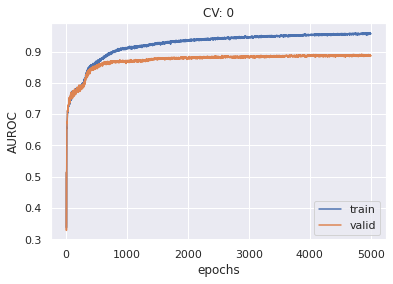

In [131]:
# AUORC
for cv in range(conf['cv']):
    fig = plt.figure()
    plt.plot(epochs, train_aurocs[cv], label='train')
    plt.plot(epochs, valid_aurocs[cv], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('AUROC')
    plt.title('CV: {}'.format(cv))
    plt.legend()
    plt.show()

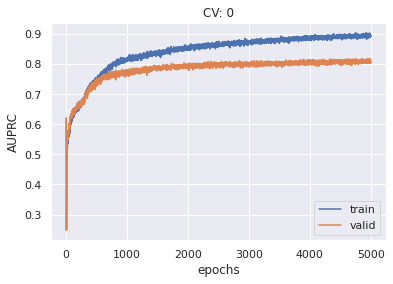

In [132]:
# AUPRC
for cv in range(conf['cv']):
    fig = plt.figure()
    plt.plot(epochs, train_auprcs[cv], label='train')
    plt.plot(epochs, valid_auprcs[cv], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('AUPRC')
    plt.title('CV: {}'.format(cv))
    plt.legend()
    plt.show()

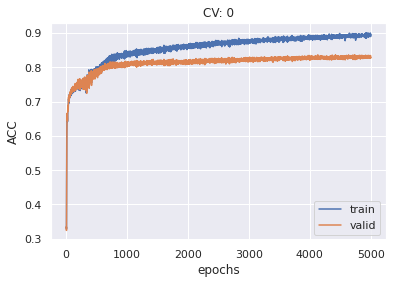

In [133]:
# ACC
for cv in range(conf['cv']):
    fig = plt.figure()
    plt.plot(epochs, train_accs[cv], label='train')
    plt.plot(epochs, valid_accs[cv], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('ACC')
    plt.title('CV: {}'.format(cv))
    plt.legend()
    plt.show()

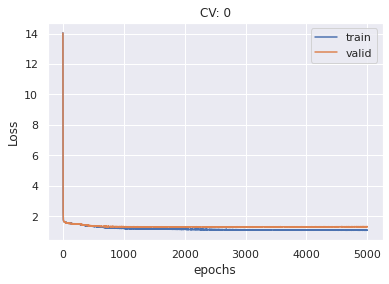

In [134]:
# loss
for cv in range(conf['cv']):
    fig = plt.figure()
    plt.plot(epochs, train_losses[cv], label='train')
    plt.plot(epochs, valid_losses[cv], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('CV: {}'.format(cv))
    plt.legend()
    plt.show()

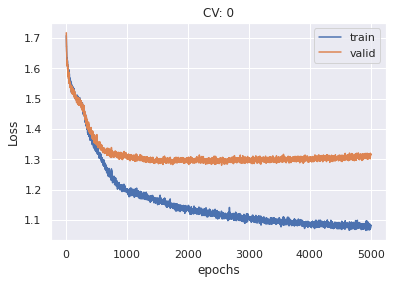

In [135]:
# loss
for cv in range(conf['cv']):
    fig = plt.figure()
    plt.plot(epochs[10:], train_losses[cv][10:], label='train')
    plt.plot(epochs[10:], valid_losses[cv][10:], label='valid')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.title('CV: {}'.format(cv))
    plt.legend()
    plt.show()

# Test result & Save model

In [136]:
def save_models(state, txt):
    dt = datetime.datetime.now()
    stamp = dt.strftime("%Y-%m-%d_%H:%M:%S")
    torch.save(state['net'], '{}_{}_ModelStates.pth'.format(stamp, txt))
    torch.save(state['optimizer'], '{}_{}_OptimizerStates.pth'.format(stamp, txt))

In [137]:
aurocs, auprcs, accs = defaultdict(list), defaultdict(list), defaultdict(list)
for i in range(conf['cv']):
    for record in best_records[i]:
        aurocs[i].append(record['AUROC'])
        auprcs[i].append(record['AUPRC'])
        accs[i].append(record['ACC'])

In [138]:
best_idx = np.argmax(np.array([auprcs[i][-1] for i in range(conf['cv'])]))
print("Best cv: {}".format(best_idx))

Best cv: 0


In [139]:
print('AUROC: {:.4f}'.format(np.array([aurocs[i][-1] for i in range(conf['cv'])])[best_idx]))
print('AUPRC: {:.4f}'.format(np.array([auprcs[i][-1] for i in range(conf['cv'])])[best_idx]))
print('ACC  : {:.4f}'.format(np.array([accs[i][-1] for i in range(conf['cv'])])[best_idx]))

AUROC: 0.9055
AUPRC: 0.8263
ACC  : 0.8449


In [140]:
if conf['save_model']:
    save_models(best_states[best_idx], 'MyModel_All_wCV')
    for key, val in node_symbols.items():
        np.save('embeddings/{}_feat.npy'.format(val), ret_feat['{}_feat'.format(val)].detach().cpu().numpy())

# New prediction

In [ ]:
def new_edge_prediction(path, data, model, device):
    model.eval()
    mat = np.loadtxt(path+'/Edge/dz.txt')
    
    # unknown drug-disease pairs
    unknown_pairs = []
    for i in range(data.n_drug):
        for j in range(data.n_diz):
            if mat[i][j] != 1:
                unknown_pairs.append([i,j])
    unknown_pairs = Tensor(np.array(unknown_pairs)).long().T
    unknown_pairs = unknown_pairs.to(device)
    unknown_pairs[1] += data.n_drug
    
    # evaluate all unknown pairs
    z_drug = data.d_feat.clone()
    z_diz = data.z_feat.clone()
    score = model.decoder(z_drug, z_diz, unknown_pairs).detach().cpu().numpy()
    unknown_pairs[1] -= data.n_drug
    score = np.concatenate([unknown_pairs.T.detach().cpu().numpy(), score], axis=1)
    
    return score

In [ ]:
def suggest_DR_pairs(path, score, num_results=10):
    # sort by link-probability
    sorted_score = score[np.argsort(score[:, 2])][::-1]
    
    # each node name
    drug_name = load_txt(path+'/Node/drug.txt')
    diz_name = load_txt(path+'/Node/disease.txt')
    
    print(f'{"Drug":20}  {"Disease":8}    {"Score":5}')
    print('_'*40+'\n')
    for i in range(num_results):
        [i,j,v] = sorted_score[i].tolist()
        print(f'{drug_name[int(i)]:20}  {diz_name[int(j)]:8} >> {v:.4f}')

In [153]:
data.d_z_edge_index

tensor([[   0,    1,    1,  ..., 4383, 4383, 4383],
        [ 450,   54,  267,  ...,  478,  617,  800]], device='cuda:3')

In [161]:
model.eval()
pos_pair = set([(x[0], x[1]) for x in data.d_z_edge_index.T.detach().cpu().numpy()])
unknown_pairs = []
for i in range(data.n_drug):
    for j in range(data.n_disease):
        if (i,j) not in pos_pair:
            unknown_pairs.append([i,j])

In [ ]:
unknown_pairs = Tensor(unknown_pairs).long().T.to(conf['device'])

In [164]:
score = model.decoder(ret_feat['d_feat'], ret_feat['z_feat'], unknown_pairs)

IndexError: tensors used as indices must be long, byte or bool tensors

# Weight Visualization

In [150]:
model.load_state_dict(state['net'])

<All keys matched successfully>

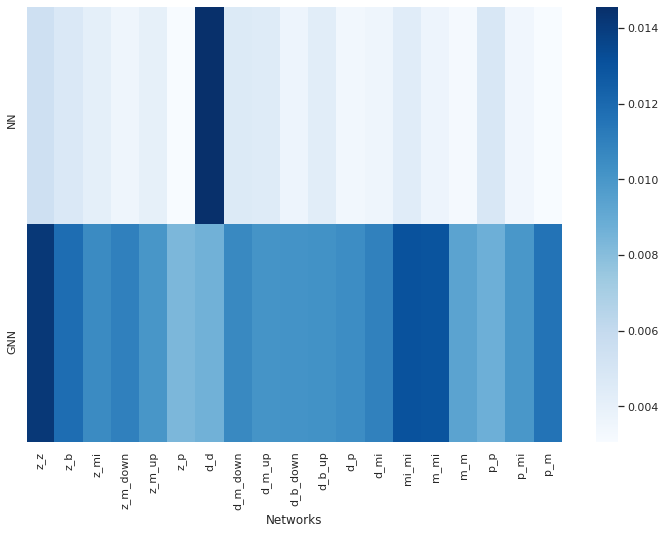

In [151]:
heatmap_modelweights(model)